Name: Write your name here

Email: Write your Email here


---



## Assignment 1: The value iteration algorithm

Your task is to solve the Robot Cleaning problem using the Value Iteration algorithm.

1- Based on your understanding write down the pseudo-code for Value Iteration algorithm.

2- Complete the implementation for value iteration algorithm. Basically you need to only complete the `MDP.state_utility()` method, comment on your results.

3- Make sure to provide your detailed explanation for the result.

4- Explain in detail the results you got in comparison with the Policy Iteration algorithm in your own words based on your understanding.


**Note:** Your grade will be based on your understanding of the algorithm and your analysis to the results. Cheating will be punished by nullifying.



# Pseudo Code 


1. denoting the value function of each state by $V(s)$ and $V$ the array containing the value of each state, we randomly initialize $V$ (for example $V(s) = 0$ for all $s$)

2. Repeat:
    
    $\Delta \leftarrow 0$ 
    
    For each state $s$ in $S$:     
    
    $$ V(s) \leftarrow \max_{a \in A} \sum_{s' \in \mathbb{S}, r \in \mathbb{R}} P(s', r | s, a) \cdot [r + \gamma \cdot V(s')]$$
    
    
    $$\Delta \leftarrow \max(\Delta, |V(s) - V'(s)|)$$

    Until $ \Delta < \epsilon$ ( $\epsilon$ is a small number)


3. Policy extraction:

    For each state $s$ in $S$: 
        
    $$\pi(s) \leftarrow \arg\max_{a \in A} \sum_{s' \in \mathbb{S}, r \in \mathbb{R}} P(s', r | s, a) \cdot [r + \gamma \cdot V(s')]$$

# Code

In [136]:
import numpy as np
import matplotlib.pyplot as plt

import random
random.seed(0)
np.random.seed(0)

In [137]:
class MDP:
	def __init__(self):
		#Starting state vector
		#The agent starts from (1, 1)
		self.states = np.array([[0.0, 0.0, 0.0, 0.0],
									[0.0, 0.0, 0.0, 0.0],
									[1.0, 0.0, 0.0, 0.0]])

		self.rewards = np.array([-0.04, -0.04, -0.04,  +1.0,
									-0.04,   0.0, -0.04,  -1.0,
									-0.04, -0.04, -0.04, -0.04])
		self.num_states = 12

		# Probabilities Transition matrix loaded from file
		#(It is too big to write here)
		self.transits = np.load("T.npy")

		#Generate the first policy randomly
		# Nan=Nothing, -1=Terminal, 0=Up, 1=Left, 2=Down, 3=Right
		self.policy = np.random.randint(0, 4, size=(12)).astype(np.float32)
		self.policy[5] = np.nan
		self.policy[3] = self.policy[7] = -1

		#Utility vector
		self.values = np.array([0.0, 0.0, 0.0,  0.0,
								0.0, 0.0, 0.0,  0.0,
								0.0, 0.0, 0.0,  0.0])
		self.gamma = 0.999

		self.epsilon = 10 ** -10
		self.iteration = 0
		

	def _state_utility_given_action(self, current_state:int, action: int) -> float:
		"""
		This function returns the value function of a state with a given action.

		sum(r, new_state) P(new_state, r | current_state, action) * (r + gamma * values[new_state])

		However, since the self.rewards is deterministic; in other words: the reward depends solely 
		on the new state r = r(new_state)

		This function computes the following:

		sum (new_state) P(new_state) * (r(new_state) + gamma * values[new_state])
		
		"""			

		# if current_state in [3, 7]:
		# 	return self.rewards[current_state].item()

		# if np.Nan simply returns the current  value function
		if np.isnan(action) :
			return self.values[current_state].item()
		
		# 2. find the probabilities of reaching the next state, from state 's' and the given action
		next_state_probs = self.transits[current_state, :, action] # [current_state, all_possible_next_states, the given action]

		su = 0
		for next_state, prob in enumerate(next_state_probs):
			su += prob * (self.rewards[next_state] + self.gamma * self.values[next_state])

		return su.item()

	def state_utility(self, s) -> float:
		# to my understanding this function is expected to return the new value of the state
		# in other words, the result of the udpate rule in the 
		# to achieve that we calculate the state utility of a new state for all the actions
		# and return the maximum value		
		all_actions = range(0, 4)

		su = -float("inf")

		for a in all_actions:
			value_action_function = self._state_utility_given_action(current_state=s, action=a)
			su = max(su, value_action_function)

		return su	

	def expected_action(self):
		"""Return the expected action.

		It returns an action based on the
		expected utility of doing a in state s,
		according to T and u. This action is
		the one that maximize the expected
		utility.

		@return expected action (int)
		"""
		actions = np.zeros(4)
		
		for action in range(4):
			#Expected utility of doing a in state s, according to T and u.
			actions[action] = np.sum(np.multiply(self.values, np.dot(self.states, self.transits[:,:,action])))

		return np.argmax(actions)
	  


In [138]:
def generate_graph(utility_list):
    """Given a list of utility arrays (one for each iteration)
        it generates a matplotlib graph and save it as 'output.jpg'
    """
    name_list = ('(1,3)', '(2,3)', '(3,3)', '+1', '(1,2)', '#', '(3,2)', '-1', '(1,1)', '(2,1)', '(3,1)', '(4,1)')
    color_list = ('cyan', 'teal', 'blue', 'green', 'magenta', 'black', 'yellow', 'red', 'brown', 'pink', 'gray', 'sienna')
    counter = 0
    index_vector = np.arange(len(utility_list))

    for state in range(12):
        state_list = list()

        for utility_array in utility_list:
            state_list.append(utility_array[state])

        plt.plot(index_vector, state_list, color=color_list[state], label=name_list[state])
        counter += 1

    #Adjust the legend and the axis
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.4), ncol=3, fancybox=True, shadow=True)
    plt.ylim((-1.1, +1.1))
    plt.xlim((1, len(utility_list)-1))
    plt.ylabel('Utility', fontsize=15)
    plt.xlabel('Iterations', fontsize=15)
    plt.savefig("./output.jpg", dpi=500)


def print_policy(p, shape):
    """Printing utility.

    Print the policy actions using symbols:
    ^, v, <, > up, down, left, right
    * terminal states
    # obstacles
    """
    counter = 0
    policy_string = ""

    for row in range(shape[0]):

        for col in range(shape[1]):
            
            if(p[counter] == -1): policy_string += " *  "
            elif(p[counter] == 0): policy_string += " ^  "
            elif(p[counter] == 1): policy_string += " <  "
            elif(p[counter] == 2): policy_string += " v  "
            elif(p[counter] == 3): policy_string += " >  "
            elif(np.isnan(p[counter])): policy_string += " #  "
            counter += 1

        policy_string += '\n'

    print(policy_string)

In [139]:
mdp = MDP()
#List containing the data for each iteation
graph_list = list()

=================== FINAL RESULT ==================
Iterations: 34
Delta: 3.574918139293004e-14
Gamma: 0.999
Epsilon: 1e-10
[0.84881226 0.90630541 0.95748948 0.        ]
[0.797764   0.         0.69906187 0.        ]
[0.7404234  0.6895106  0.64536512 0.42192624]
 >   >   <   *  
 ^   #   ^   *  
 ^   <   <   <  



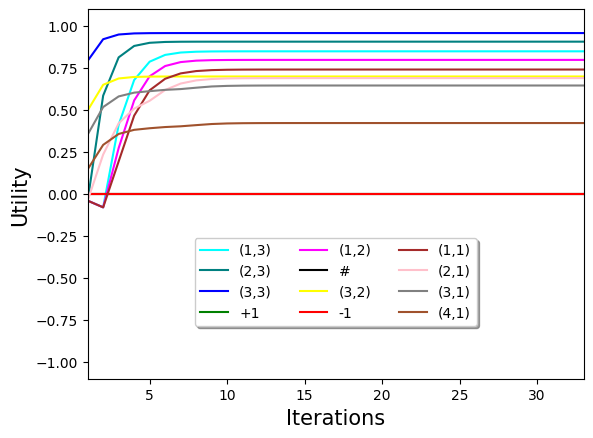

In [140]:
while True:
    
    delta = 0
    # u = mdp.values
    u_old = mdp.values.copy()
    mdp.iteration += 1
    graph_list.append(u_old)
    
    for s in range(12):
        mdp.states = np.zeros((1,mdp.num_states))
        mdp.states[0,s] = 1.0
        mdp.values[s] = mdp.state_utility(s)
        u = mdp.values.copy()
        delta = max(delta, np.abs(u[s] - u_old[s])) #Stopping criteria

    # u[3] = 1
    # u[7] = -1
     

    if delta < mdp.epsilon * (1 - mdp.gamma) / mdp.gamma:
            # mdp.values[3] = 1
            # mdp.values[7] = -1

            print("=================== FINAL RESULT ==================")
            print("Iterations: " + str(mdp.iteration))
            print("Delta: " + str(delta))
            print("Gamma: " + str(mdp.gamma))
            print("Epsilon: " + str(mdp.epsilon))
            print("===================================================")
            print(u[0:4])
            print(u[4:8])
            print(u[8:12])
            print("===================================================")

            for ss in range(12):

              if not np.isnan(mdp.policy[ss]) and not mdp.policy[ss]==-1:
                  mdp.states = np.zeros((1,12))
                  mdp.states[0,ss] = 1.0
                  #2- Policy improvement
                  a = mdp.expected_action()
                  if a != mdp.policy[ss]: mdp.policy[ss] = a

            print_policy(mdp.policy, shape=(3,4))
            print("===================================================")
            break

generate_graph(graph_list)

# Results Explanation



# 